# Provide Prompt Weight and Unlock 77 token limitations

## The 77 token limitation

In [1]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype=torch.float16
    , safety_checker = None
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers

  0%|          | 0/50 [00:00<?, ?it/s]

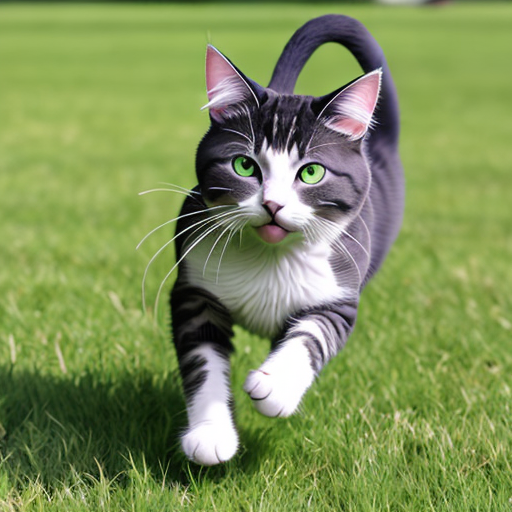

In [2]:
prompt = "photo, cat running on the grass"
image = pipe(
    prompt = prompt
).images[0]
image

## Understanding the 77-token limitation

In [3]:
prompt = "photo, cat running on the grass"

tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

max_length = pipe.tokenizer.model_max_length

tokens = tokenizer(
    prompt
    #, truncation=True
    , return_tensors = 'pt'
)["input_ids"]
print(len(tokens[0]))
print(tokens[0])

# token_ids = tokenizer.convert_tokens_to_ids(tokens)
# print(tokens)
# print(token_ids)

embeddings = pipe.text_encoder(
    tokens.to("cuda")
)[0]
print(embeddings.shape)
print(embeddings)

9
tensor([49406,  1125,   267,  2368,  2761,   525,   518,  5922, 49407])
torch.Size([1, 9, 768])
tensor([[[-0.3794,  0.0197, -0.0576,  ..., -0.4924, -0.3044,  0.0684],
         [ 0.7275,  0.1788,  1.2529,  ..., -1.6318,  0.0898, -0.9180],
         [ 1.6611,  1.0391,  1.3047,  ..., -0.8442,  0.4998,  0.5239],
         ...,
         [-1.3604,  0.6123, -0.3762,  ..., -0.3811,  0.6968, -0.0909],
         [ 0.0598, -0.9575,  1.9141,  ..., -0.3389,  0.1116, -0.8467],
         [-1.5254,  0.4155,  0.5010,  ..., -1.4004,  0.6328, -0.8657]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)


In [4]:
begin_token_id = tokenizer.convert_tokens_to_ids("<|clip|>")
end_token_id = tokenizer.convert_tokens_to_ids("<|endofclip|>")

print(begin_token_id, end_token_id)

49407 49407


In [5]:
print(tokenizer._convert_id_to_token(49406))
print(tokenizer._convert_id_to_token(49407))

<|startoftext|>
<|endoftext|>


## Unlocking the 77-token limitation

### Unlock without weight

In [6]:
def long_prompt_encoding(
    pipe:StableDiffusionPipeline
    , prompt
    , neg_prompt = ""
):
    bos = pipe.tokenizer.bos_token_id
    eos = pipe.tokenizer.eos_token_id
    chunk_size = 75
    
    # step 1. take out the tokenizer and text encoder
    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder

    # step 2.1. encode whatever size prompt to tokens by setting truncation = False.
    tokens = tokenizer(
        prompt
        , truncation = False
        #, return_tensors = 'pt'
    )["input_ids"]
    
    # step 2.2. encode whatever size neg_prompt, padding it to the size of prompt.
    negative_ids = pipe.tokenizer(
        neg_prompt
        , truncation    = False
        #, return_tensors = "pt"
        , padding       = "max_length"
        , max_length    = len(tokens)
    ).input_ids         
    
    # Step 3. remove begin and end tokens
    tokens = tokens[1:-1]
    negative_ids = negative_ids[1:-1]

    # step 4. Pop out the head 77 tokens, and encode the 77 tokens to embeddings. 
    embeds,neg_embeds = [],[]
    for i in range(0, len(tokens), chunk_size):
        # Add begin and end token to the 75 chunked tokens to make a 77 token list
        sub_tokens          = [bos] + tokens[i:i + chunk_size] + [eos]
        
        # text_encoder support torch.Size([1,x]) input tensor 
        # that is why use [sub_tokens], instead of simply give sub_tokens.
        tensor_tokens       = torch.tensor(
            [sub_tokens]
            , dtype = torch.long
            , device = pipe.device
        )
        chunk_embeds        = text_encoder(tensor_tokens)[0]
        embeds.append(chunk_embeds)
        
        # Add begin and end token to the 75 chunked neg tokens to make a 77 token list   
        sub_neg_tokens      = [bos] + negative_ids[i:i + chunk_size] + [eos] 
        tensor_neg_tokens   = torch.tensor(
            [sub_neg_tokens]
            , dtype = torch.long
            , device = pipe.device
        )
        neg_chunk_embeds    = text_encoder(tensor_neg_tokens)[0]
        neg_embeds.append(neg_chunk_embeds)

    # step 5. Stack the embeddings to a [1,x,768] size torch tensor. 
    prompt_embeds = torch.cat(embeds, dim = 1)
    prompt_neg_embeds = torch.cat(neg_embeds, dim = 1)
    
    return prompt_embeds, prompt_neg_embeds

Token indices sequence length is longer than the specified maximum sequence length for this model (82 > 77). Running this sequence through the model will result in indexing errors


  0%|          | 0/50 [00:00<?, ?it/s]

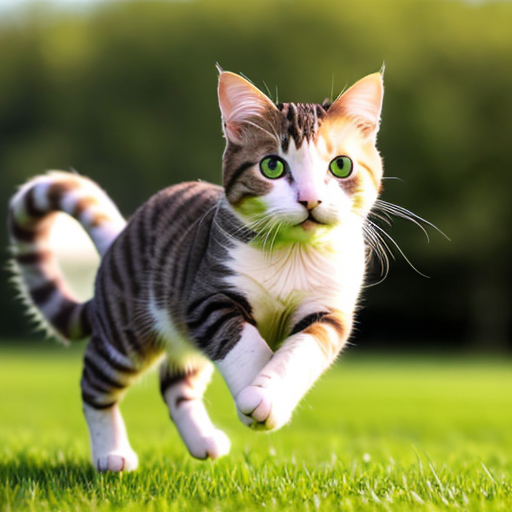

In [7]:
prompt = "photo, cute cat running on the grass" * 10
prompt_embeds, prompt_neg_embeds = long_prompt_encoding(
    pipe, prompt, neg_prompt="low resolution, bad anatomy"
)

image = pipe(
    prompt_embeds = prompt_embeds
    , negative_prompt_embeds = prompt_neg_embeds
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

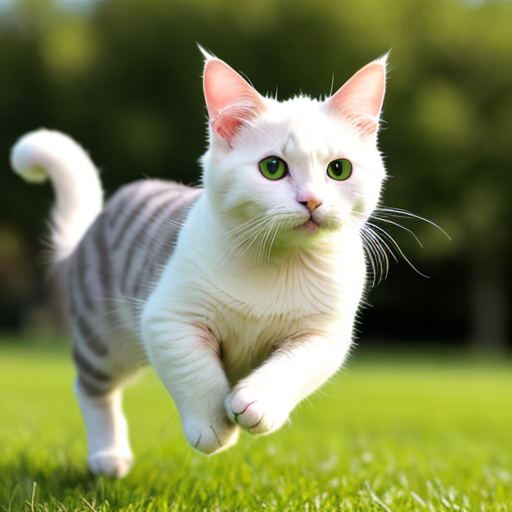

In [8]:
prompt = "photo, cute cat running on the grass" * 10
prompt = prompt + ",pure white cat" * 10
prompt_embeds, prompt_neg_embeds = long_prompt_encoding(
    pipe, prompt, neg_prompt="low resolution, bad anatomy"*5
)

image = pipe(
    prompt_embeds = prompt_embeds
    , negative_prompt_embeds = prompt_neg_embeds
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

### Unlock 77 tokens and add prompt weighting

In [9]:
# step 1. parse prmopt attention
# source: 
def parse_prompt_attention(text):
    """
    Parses a string with attention tokens and returns a list of pairs: text and its associated weight.
    Accepted tokens are:
      (abc) - increases attention to abc by a multiplier of 1.1
      (abc:3.12) - increases attention to abc by a multiplier of 3.12
      [abc] - decreases attention to abc by a multiplier of 1.1
      \( - literal character '('
      \[ - literal character '['
      \) - literal character ')'
      \] - literal character ']'
      \\ - literal character '\'
      anything else - just text

    >>> parse_prompt_attention('normal text')
    [['normal text', 1.0]]
    >>> parse_prompt_attention('an (important) word')
    [['an ', 1.0], ['important', 1.1], [' word', 1.0]]
    >>> parse_prompt_attention('(unbalanced')
    [['unbalanced', 1.1]]
    >>> parse_prompt_attention('\(literal\]')
    [['(literal]', 1.0]]
    >>> parse_prompt_attention('(unnecessary)(parens)')
    [['unnecessaryparens', 1.1]]
    >>> parse_prompt_attention('a (((house:1.3)) [on] a (hill:0.5), sun, (((sky))).')
    [['a ', 1.0],
     ['house', 1.5730000000000004],
     [' ', 1.1],
     ['on', 1.0],
     [' a ', 1.1],
     ['hill', 0.55],
     [', sun, ', 1.1],
     ['sky', 1.4641000000000006],
     ['.', 1.1]]
    """
    import re
    re_attention = re.compile(
        r"""
            \\\(|\\\)|\\\[|\\]|\\\\|\\|\(|\[|:([+-]?[.\d]+)\)|
            \)|]|[^\\()\[\]:]+|:
        """
        , re.X
    )

    re_break = re.compile(r"\s*\bBREAK\b\s*", re.S)
    
    res = []
    round_brackets = []
    square_brackets = []

    round_bracket_multiplier = 1.1
    square_bracket_multiplier = 1 / 1.1

    def multiply_range(start_position, multiplier):
        for p in range(start_position, len(res)):
            res[p][1] *= multiplier

    for m in re_attention.finditer(text):
        text = m.group(0)
        weight = m.group(1)

        if text.startswith('\\'):
            res.append([text[1:], 1.0])
        elif text == '(':
            round_brackets.append(len(res))
        elif text == '[':
            square_brackets.append(len(res))
        elif weight is not None and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), float(weight))
        elif text == ')' and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), round_bracket_multiplier)
        elif text == ']' and len(square_brackets) > 0:
            multiply_range(square_brackets.pop(), square_bracket_multiplier)
        else:
            parts = re.split(re_break, text)
            for i, part in enumerate(parts):
                if i > 0:
                    res.append(["BREAK", -1])
                res.append([part, 1.0])

    for pos in round_brackets:
        multiply_range(pos, round_bracket_multiplier)

    for pos in square_brackets:
        multiply_range(pos, square_bracket_multiplier)

    if len(res) == 0:
        res = [["", 1.0]]

    # merge runs of identical weights
    i = 0
    while i + 1 < len(res):
        if res[i][1] == res[i + 1][1]:
            res[i][0] += res[i + 1][0]
            res.pop(i + 1)
        else:
            i += 1

    return res

In [10]:
parse_prompt_attention("a (\(white\)) cat")

[['a ', 1.0], ['(white)', 1.1], [' cat', 1.0]]

In [11]:
# step 2. get prompts with weights
# this function works for both prompt and negative prompt
def get_prompts_tokens_with_weights(
    pipe: StableDiffusionPipeline
    , prompt: str
):
    texts_and_weights = parse_prompt_attention(prompt)
    text_tokens,text_weights = [],[]
    for word, weight in texts_and_weights:
        # tokenize and discard the starting and the ending token
        token = pipe.tokenizer(
            word
            , truncation = False        # so that tokenize whatever length prompt
        ).input_ids[1:-1]
        # the returned token is a 1d list: [320, 1125, 539, 320]
        
        # merge the new tokens to the all tokens holder: text_tokens
        text_tokens = [*text_tokens,*token]
        
        # each token chunk will come with one weight, like ['red cat', 2.0]
        # need to expand weight for each token.
        chunk_weights = [weight] * len(token) 
        
        # append the weight back to the weight holder: text_weights
        text_weights = [*text_weights, *chunk_weights]
    return text_tokens,text_weights
        
# prompt = "a photo of a cat driving an aircraft," * 10
# prompt = prompt + ", a (bird:1.7) is flying side by side"

prompt = "a (white) cat"
tokens, weights = get_prompts_tokens_with_weights(pipe, prompt)
print(tokens,weights)


[320, 1579, 2368] [1.0, 1.1, 1.0]


In [12]:
# step 3. padding tokens
def pad_tokens_and_weights(
    token_ids: list
    , weights: list
):
    bos,eos = 49406,49407
    
    # this will be a 2d list 
    new_token_ids = []
    new_weights   = []  
    while len(token_ids) >= 75:
        # get the first 75 tokens
        head_75_tokens = [token_ids.pop(0) for _ in range(75)]
        head_75_weights = [weights.pop(0) for _ in range(75)]
        
        # extract token ids and weights
        temp_77_token_ids = [bos] + head_75_tokens + [eos]
        temp_77_weights   = [1.0] + head_75_weights + [1.0]
        
        # add 77 token and weights chunk to the holder list
        new_token_ids.append(temp_77_token_ids)
        new_weights.append(temp_77_weights)
    
    # padding the left
    if len(token_ids) > 0:
        padding_len         = 75 - len(token_ids)
        padding_len = 0
        
        temp_77_token_ids   = [bos] + token_ids + [eos] * padding_len + [eos]
        new_token_ids.append(temp_77_token_ids)
        
        temp_77_weights     = [1.0] + weights   + [1.0] * padding_len + [1.0]
        new_weights.append(temp_77_weights)
        
    # return
    return new_token_ids, new_weights

t,w = pad_tokens_and_weights(tokens.copy(), weights.copy())
print(t)
print(w)


[[49406, 320, 1579, 2368, 49407]]
[[1.0, 1.0, 1.1, 1.0, 1.0]]


In [13]:
# encode "white" only
white_token = 1579
white_token_tensor = torch.tensor(
    [[white_token]]
    , dtype = torch.long
    , device = pipe.device
)
white_embed = pipe.text_encoder(white_token_tensor)[0]
print(white_embed[0][0])

tensor([-3.2642e-01,  1.1871e-02, -5.8502e-02, -1.4795e-01, -4.5013e-02,
        -3.7500e-01, -2.2400e-02, -1.9434e-01,  1.5942e-01, -5.0110e-02,
        -1.9531e-01, -1.4697e-01, -7.6660e-02, -3.2178e-01,  7.5562e-02,
        -1.1133e-01, -1.1157e-01, -7.8796e-02,  6.2073e-02, -2.8078e+01,
        -1.2659e-01, -1.7566e-01, -1.0529e-01, -9.3628e-02, -1.2213e-01,
        -1.0596e-01, -1.6980e-01, -1.9519e-01, -2.7808e-01, -4.4434e-02,
        -4.5441e-02, -9.9670e-02, -9.1309e-02, -7.5195e-02, -2.1191e-01,
        -2.9761e-01, -3.6597e-01, -9.1187e-02, -9.4116e-02,  1.9516e-02,
        -1.7529e-01, -1.4709e-01, -1.8018e-01, -2.1130e-01, -2.1252e-01,
        -2.8394e-01,  2.9343e-02, -1.6321e-01, -3.7695e-01, -1.5173e-01,
         7.4148e-04, -5.5084e-02, -2.5073e-01, -1.0577e-01, -2.7905e-01,
        -3.4082e-01, -2.0798e-02, -1.4307e-01, -3.0347e-01,  9.5581e-02,
         6.5613e-03, -1.0974e-01, -2.0679e-01, -2.2876e-01, -2.6953e-01,
        -2.4841e-01, -3.6572e-01, -2.6245e-01, -1.4

In [14]:
# encode "white cat"
white_token, cat_token = 1579, 2369
white_cat_token_tensor = torch.tensor(
    [[white_token, cat_token]]
    , dtype = torch.long
    , device = pipe.device
)
white_cat_embeds = pipe.text_encoder(white_cat_token_tensor)[0]
print(white_cat_embeds[0][0])

tensor([-3.2642e-01,  1.1871e-02, -5.8502e-02, -1.4795e-01, -4.5013e-02,
        -3.7500e-01, -2.2400e-02, -1.9421e-01,  1.5942e-01, -5.0110e-02,
        -1.9531e-01, -1.4697e-01, -7.6660e-02, -3.2178e-01,  7.5562e-02,
        -1.1139e-01, -1.1163e-01, -7.8796e-02,  6.2073e-02, -2.8078e+01,
        -1.2659e-01, -1.7554e-01, -1.0529e-01, -9.3628e-02, -1.2213e-01,
        -1.0596e-01, -1.6980e-01, -1.9531e-01, -2.7808e-01, -4.4434e-02,
        -4.5441e-02, -9.9609e-02, -9.1248e-02, -7.5195e-02, -2.1191e-01,
        -2.9761e-01, -3.6597e-01, -9.1187e-02, -9.4116e-02,  1.9562e-02,
        -1.7529e-01, -1.4709e-01, -1.8018e-01, -2.1118e-01, -2.1252e-01,
        -2.8394e-01,  2.9327e-02, -1.6309e-01, -3.7695e-01, -1.5173e-01,
         7.4148e-04, -5.5084e-02, -2.5073e-01, -1.0577e-01, -2.7905e-01,
        -3.4082e-01, -2.0813e-02, -1.4307e-01, -3.0347e-01,  9.5581e-02,
         6.5613e-03, -1.0974e-01, -2.0679e-01, -2.2876e-01, -2.6953e-01,
        -2.4841e-01, -3.6572e-01, -2.6245e-01, -1.4

In [15]:
# Step 4. get weighted embeddings
def get_weighted_text_embeddings(
    pipe: StableDiffusionPipeline
    , prompt : str      = ""
    , neg_prompt: str   = ""
):
    eos = pipe.tokenizer.eos_token_id 
    prompt_tokens, prompt_weights = get_prompts_tokens_with_weights(
        pipe, prompt
    )
    neg_prompt_tokens, neg_prompt_weights = get_prompts_tokens_with_weights(
        pipe, neg_prompt
    )
    
    # padding the shorter one
    prompt_token_len        = len(prompt_tokens)
    neg_prompt_token_len    = len(neg_prompt_tokens)
    if prompt_token_len > neg_prompt_token_len:
        # padding the neg_prompt with eos token
        neg_prompt_tokens   = (
            neg_prompt_tokens  + 
            [eos] * abs(prompt_token_len - neg_prompt_token_len)
        )
        neg_prompt_weights  = (
            neg_prompt_weights + 
            [1.0] * abs(prompt_token_len - neg_prompt_token_len)
        )
    else:
        # padding the prompt
        prompt_tokens       = (
            prompt_tokens  
            + [eos] * abs(prompt_token_len - neg_prompt_token_len)
        )
        prompt_weights      = (
            prompt_weights 
            + [1.0] * abs(prompt_token_len - neg_prompt_token_len)
        )
    
    embeds = []
    neg_embeds = []
    
    prompt_token_groups ,prompt_weight_groups = pad_tokens_and_weights(
        prompt_tokens.copy()
        , prompt_weights.copy()
    )
    
    neg_prompt_token_groups, neg_prompt_weight_groups = pad_tokens_and_weights(
        neg_prompt_tokens.copy()
        , neg_prompt_weights.copy()
    )
        
    # get prompt embeddings one by one is not working. 
    for i in range(len(prompt_token_groups)):
        # get positive prompt embeddings with weights
        token_tensor = torch.tensor(
            [prompt_token_groups[i]]
            ,dtype = torch.long, device = pipe.device
        )
        weight_tensor = torch.tensor(
            prompt_weight_groups[i]
            , dtype     = torch.float16
            , device    = pipe.device
        )
        token_embedding = pipe.text_encoder(token_tensor)[0].squeeze(0) 
        for j in range(len(weight_tensor)):
            token_embedding[j] = token_embedding[j] * weight_tensor[j]
        token_embedding = token_embedding.unsqueeze(0)
        embeds.append(token_embedding)
        
        # get negative prompt embeddings with weights
        neg_token_tensor = torch.tensor(
            [neg_prompt_token_groups[i]]
            , dtype = torch.long, device = pipe.device
        )
        neg_weight_tensor = torch.tensor(
            neg_prompt_weight_groups[i]
            , dtype     = torch.float16
            , device    = pipe.device
        )
        neg_token_embedding = pipe.text_encoder(neg_token_tensor)[0].squeeze(0) 
        for z in range(len(neg_weight_tensor)):
            neg_token_embedding[z] = (
                neg_token_embedding[z] * neg_weight_tensor[z]
            )
        neg_token_embedding = neg_token_embedding.unsqueeze(0)
        neg_embeds.append(neg_token_embedding)
    
    prompt_embeds       = torch.cat(embeds, dim = 1)
    neg_prompt_embeds   = torch.cat(neg_embeds, dim = 1)
    
    return prompt_embeds, neg_prompt_embeds


prompt = "photo, cute cat running on the grass" * 10
prompt = prompt + ",pure (white:1.5) cat" * 10

neg_prompt = "low resolution, bad anatomy"

prompt_embeds, prompt_neg_embeds = get_weighted_text_embeddings(pipe, prompt = prompt, neg_prompt = neg_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

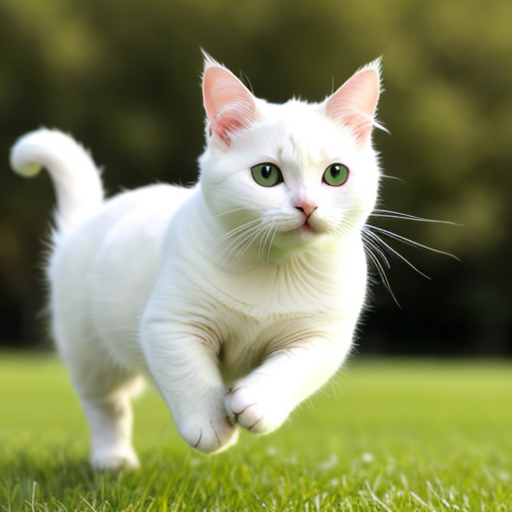

In [16]:
image = pipe(
    prompt_embeds = prompt_embeds
    , negative_prompt_embeds = prompt_neg_embeds
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

## Long weighted prompt community pipeline

### Long Prompt Weight Pipeline for Stable Diffusion V1.5 from community

In [17]:
from diffusers import DiffusionPipeline
import torch

model_id_or_path = "stablediffusionapi/deliberate-v2"
pipe = DiffusionPipeline.from_pretrained(   
    model_id_or_path
    , torch_dtype       = torch.float16
    , custom_pipeline   = "lpw_stable_diffusion"
).to("cuda:0")

v0.32.1/lpw_stable_diffusion.py:   0%|          | 0.00/74.7k [00:00<?, ?B/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\datasets--diffusers--community-pipelines-mirror. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors


  0%|          | 0/50 [00:00<?, ?it/s]

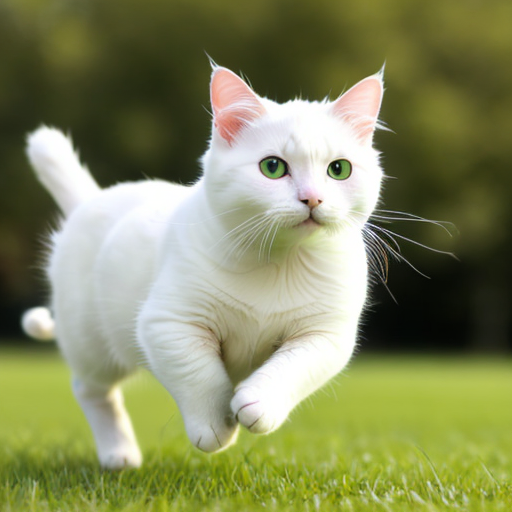

In [18]:
prompt = "photo, cute cat running on the grass" * 10
prompt = prompt + ",pure (white:1.5) cat" * 10

neg_prompt = "low resolution, bad anatomy"
image = pipe(
    prompt = prompt
    , negative_prompt = neg_prompt
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

### Long Prompt Weight Pipeline for Stable Diffusion XL from community

In [19]:
from diffusers import DiffusionPipeline
import torch

model_id_or_path = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(
    model_id_or_path
    , torch_dtype       = torch.float16
    , custom_pipeline   = "lpw_stable_diffusion_xl",
).to("cuda:0")

(…)les/community/lpw_stable_diffusion_xl.py:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors


  0%|          | 0/50 [00:00<?, ?it/s]

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


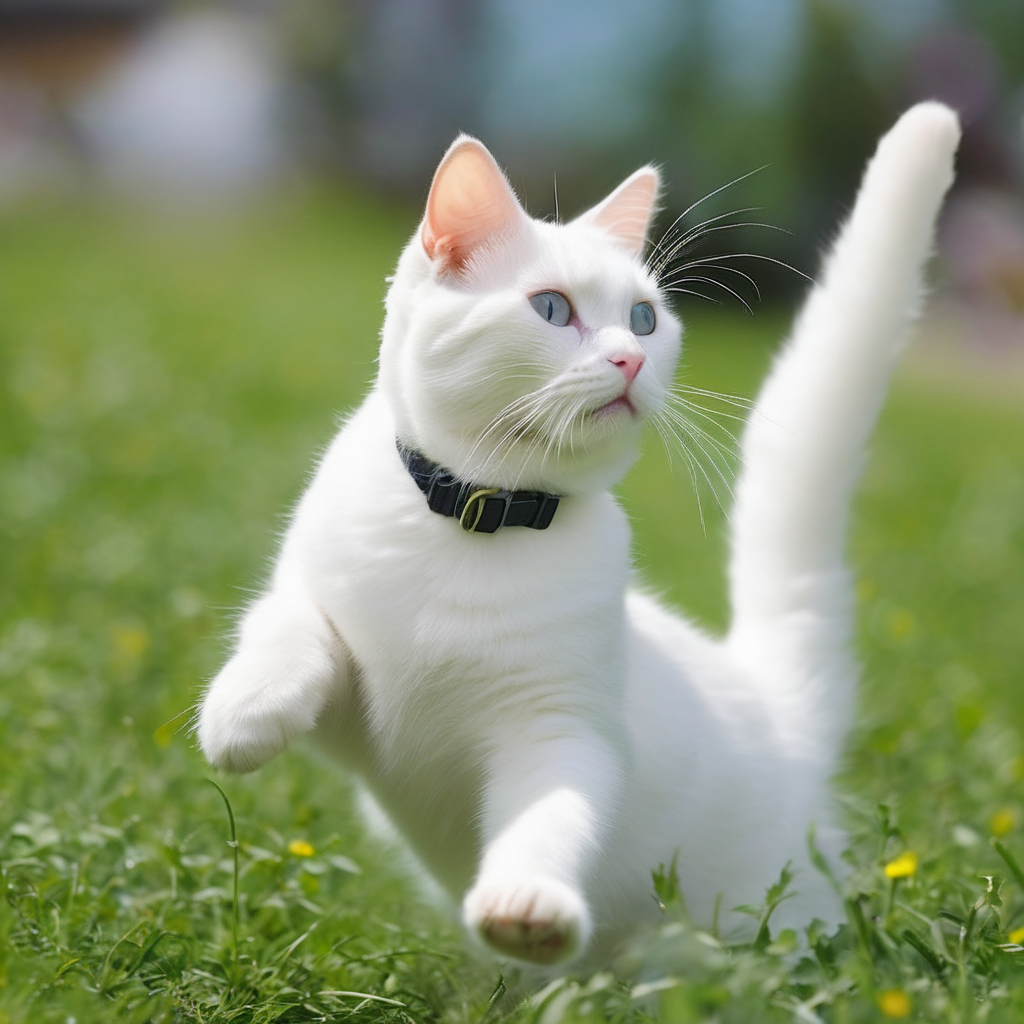

In [20]:
prompt = "photo, cute cat running on the grass" * 10
prompt = prompt + ",pure (white:1.5) cat" * 10

neg_prompt = "low resolution, bad anatomy"
image = pipe(
    prompt = prompt
    , negative_prompt = neg_prompt
    , generator = torch.Generator("cuda").manual_seed(7)
).images[0]
image